# 🎵 VAE Music Clustering - FINAL VERSION

**Complete Implementation covering Easy, Medium & Hard Tasks**

Features:
- ✅ Hybrid CNN-VAE (Audio + Lyrics)
- ✅ Beta-VAE for disentanglement
- ✅ Multiple clustering algorithms
- ✅ Complete metrics suite
- ✅ Reconstruction visualization
- ✅ Confusion matrix analysis

## 1️⃣ Setup & Imports

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
)

try:
    import umap
    HAS_UMAP = True
except:
    HAS_UMAP = False
    print("UMAP not available, will skip UMAP visualizations")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

🖥️ Using device: cuda


## 2️⃣ Mount Drive & Configuration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ⚠️ UPDATE THESE PATHS
DRIVE_PATH = '/content/drive/MyDrive/VAE_Music_Clustering_Project'
CSV_PATH = f'{DRIVE_PATH}/Music Dataset - Sheet1.csv'
AUDIO_PATH = f'{DRIVE_PATH}/wav_files'
SAVE_DIR = f'{DRIVE_PATH}/results/final'
os.makedirs(SAVE_DIR, exist_ok=True)

# Hyperparameters
CONFIG = {
    'latent_dim': 32,
    'epochs': 100,
    'batch_size': 64,
    'lr': 5e-4,
    'beta_start': 0.0,
    'beta_end': 1.0,
    'beta_warmup': 50,
    'n_mfcc': 20,
    'max_audio_len': 130,
    'text_dim': 64,
    'audio_weight': 1.0,
    'text_weight': 0.1
}

print(f"📂 Save directory: {SAVE_DIR}")
print(f"⚙️ Config: {CONFIG}")

📂 Save directory: /content/drive/MyDrive/VAE_Music_Clustering_Project/results/final
⚙️ Config: {'latent_dim': 32, 'epochs': 100, 'batch_size': 64, 'lr': 0.0005, 'beta_start': 0.0, 'beta_end': 1.0, 'beta_warmup': 50, 'n_mfcc': 20, 'max_audio_len': 130, 'text_dim': 64, 'audio_weight': 1.0, 'text_weight': 0.1}


In [4]:
# Load dataset
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} songs")
print(f"Columns: {df.columns.tolist()}")
print(f"\nGenre Distribution:")
print(df['playlist_genre'].value_counts())

📊 Loaded 3103 songs
📋 Columns: ['track_name', 'lyrics', 'playlist_genre']

🎵 Genre Distribution:
playlist_genre
pop      673
rock     606
rap      586
r&b      543
edm      350
latin    345
Name: count, dtype: int64


## 3️⃣ Audio-Lyrics Matching

In [5]:
def clean_track_name(name):
    """Clean track name for matching with audio files"""
    name = str(name).lower()
    name = re.sub(r'[^a-z0-9]', '_', name)
    name = re.sub(r'_+', '_', name)
    return name.strip('_')

# Create lookup dictionary
df['clean_name'] = df['track_name'].apply(clean_track_name)
df['lyrics'] = df['lyrics'].fillna("")

track_lookup = {}
for _, row in df.iterrows():
    track_lookup[row['clean_name']] = {
        'lyrics': row['lyrics'],
        'genre': row['playlist_genre'],
        'original_name': row['track_name']
    }

print(f"✅ Created lookup for {len(track_lookup)} tracks")

# Preview matching
audio_files_preview = [f for f in os.listdir(AUDIO_PATH) if f.endswith('.wav')][:5]
print("\n🔍 Matching Preview:")
for f in audio_files_preview:
    clean = f.replace('.wav', '').replace('_30s', '')
    status = "✅" if clean in track_lookup else "❌"
    print(f"  {f} → {clean} {status}")

✅ Created lookup for 2944 tracks

🔍 Matching Preview:
  my_homeboy_s_girlfriend_30s.wav → my_homeboy_s_girlfriend ✅
  friends_and_lovers_feat_gloria_loring_30s.wav → friends_and_lovers_feat_gloria_loring ✅
  animals_original_mix_30s.wav → animals_original_mix ✅
  this_year_s_love_30s.wav → this_year_s_love ✅
  bon_bon_chocolat_30s.wav → bon_bon_chocolat ✅


## 4️⃣ Feature Extraction

In [6]:
def extract_audio_features(file_path, n_mfcc=20, max_len=130):
    """Extract MFCC + Chroma + Spectral Contrast features"""
    try:
        y, sr = librosa.load(file_path, sr=22050, duration=30)

        # MFCC (20 coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Chroma (12 pitch classes)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        # Spectral Contrast (7 bands)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # Stack: 20 + 12 + 7 = 39 features
        combined = np.vstack([mfcc, chroma, contrast])

        # Pad or truncate
        if combined.shape[1] < max_len:
            combined = np.pad(combined, ((0, 0), (0, max_len - combined.shape[1])), mode='constant')
        else:
            combined = combined[:, :max_len]

        return combined
    except Exception as e:
        return None

In [8]:
print(" Extracting features...")
audio_files = [f for f in os.listdir(AUDIO_PATH) if f.endswith('.wav')]

X_audio_list, X_lyrics_list, valid_genres, valid_files, valid_names = [], [], [], [], []
matched, unmatched = 0, 0

for audio_file in tqdm(audio_files, desc="Processing audio"):
    clean_audio = audio_file.replace('.wav', '').replace('_30s', '')

    if clean_audio in track_lookup:
        file_path = os.path.join(AUDIO_PATH, audio_file)
        features = extract_audio_features(file_path, CONFIG['n_mfcc'], CONFIG['max_audio_len'])

        if features is not None:
            X_audio_list.append(features)
            X_lyrics_list.append(track_lookup[clean_audio]['lyrics'])
            valid_genres.append(track_lookup[clean_audio]['genre'])
            valid_files.append(audio_file)
            valid_names.append(track_lookup[clean_audio]['original_name'])
            matched += 1
    else:
        unmatched += 1

print(f"\n✅ Matched & Processed: {matched}")
print(f"❌ Unmatched: {unmatched}")

 Extracting features...


Processing audio: 100%|██████████| 2891/2891 [17:17<00:00,  2.79it/s]


✅ Matched & Processed: 2890
❌ Unmatched: 1


In [9]:
# Process audio features
X_audio = np.array(X_audio_list)
print(f"🎵 Audio shape: {X_audio.shape}")

# Process lyrics with TF-IDF
print("Processing lyrics...")
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', min_df=2)
tfidf_matrix = vectorizer.fit_transform(X_lyrics_list).toarray()

# PCA for dimensionality reduction
pca_text = PCA(n_components=min(CONFIG['text_dim'], tfidf_matrix.shape[1]))
X_text = pca_text.fit_transform(tfidf_matrix)
print(f"Text shape: {X_text.shape}")

# Normalize features
N, n_feat, max_len = X_audio.shape
X_audio_flat = X_audio.reshape(N, -1)

scaler_audio = StandardScaler()
X_audio_scaled = scaler_audio.fit_transform(X_audio_flat)
X_audio_cnn = X_audio_scaled.reshape(N, 1, n_feat, max_len)

scaler_text = StandardScaler()
X_text_scaled = scaler_text.fit_transform(X_text)

# Encode genres
label_encoder = LabelEncoder()
y_genres = label_encoder.fit_transform(valid_genres)
genre_names = list(label_encoder.classes_)

print(f"\nFinal shapes:")
print(f"   Audio: {X_audio_cnn.shape}")
print(f"   Text: {X_text_scaled.shape}")
print(f"   Genres: {genre_names}")

🎵 Audio shape: (2890, 39, 130)
📝 Processing lyrics...
📝 Text shape: (2890, 64)

📊 Final shapes:
   Audio: (2890, 1, 39, 130)
   Text: (2890, 64)
   Genres: [np.str_('edm'), np.str_('latin'), np.str_('pop'), np.str_('r&b'), np.str_('rap'), np.str_('rock')]


## 5️⃣ Beta-VAE Architecture

In [10]:
class BetaHybridVAE(nn.Module):
    """
    Hybrid Variational Autoencoder with Beta-VAE formulation
    for disentangled latent representations.

    Architecture:
    - Audio Encoder: CNN (Conv2d layers)
    - Text Encoder: MLP
    - Latent Space: Gaussian with reparameterization
    - Audio Decoder: Transposed CNN
    - Text Decoder: MLP
    """

    def __init__(self, n_feat=39, max_len=130, text_dim=64, latent_dim=32):
        super().__init__()
        self.n_feat = n_feat
        self.max_len = max_len
        self.latent_dim = latent_dim

        # ========== AUDIO ENCODER ==========
        self.audio_enc = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.1),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.1),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        # Calculate dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_feat, max_len)
            enc_out = self.audio_enc(dummy)
            self.audio_flat_dim = enc_out.shape[1]

            # Get spatial dimensions before flatten
            conv_layers = nn.Sequential(*list(self.audio_enc.children())[:-1])
            conv_out = conv_layers(dummy)
            self.enc_c = conv_out.shape[1]
            self.enc_h = conv_out.shape[2]
            self.enc_w = conv_out.shape[3]

        # ========== TEXT ENCODER ==========
        self.text_enc = nn.Sequential(
            nn.Linear(text_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # ========== LATENT SPACE ==========
        self.fusion_dim = self.audio_flat_dim + 32
        self.fc_mu = nn.Linear(self.fusion_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fusion_dim, latent_dim)

        # Initialize logvar to small values to prevent explosion
        nn.init.zeros_(self.fc_logvar.weight)
        nn.init.constant_(self.fc_logvar.bias, -2.0)

        # ========== AUDIO DECODER ==========
        self.audio_dec_input = nn.Linear(latent_dim, self.audio_flat_dim)
        self.audio_dec = nn.Sequential(
            nn.Unflatten(1, (self.enc_c, self.enc_h, self.enc_w)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        )

        # ========== TEXT DECODER ==========
        self.text_dec = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, text_dim)
        )

        self.target_shape = (n_feat, max_len)

    def encode(self, x_audio, x_text):
        h_audio = self.audio_enc(x_audio)
        h_text = self.text_enc(x_text)
        h = torch.cat([h_audio, h_text], dim=1)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        # Clamp to prevent numerical instability
        logvar = torch.clamp(logvar, min=-10, max=2)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Audio reconstruction
        h_audio = self.audio_dec_input(z)
        recon_audio = self.audio_dec(h_audio)

        # Text reconstruction
        recon_text = self.text_dec(z)

        return recon_audio, recon_text

    def forward(self, x_audio, x_text):
        mu, logvar = self.encode(x_audio, x_text)
        z = self.reparameterize(mu, logvar)
        recon_audio, recon_text = self.decode(z)

        # Resize audio if needed
        if recon_audio.shape[2:] != x_audio.shape[2:]:
            recon_audio = nn.functional.interpolate(
                recon_audio, size=self.target_shape,
                mode='bilinear', align_corners=False
            )

        return recon_audio, recon_text, mu, logvar, z

    def get_latent(self, x_audio, x_text):
        """Get latent representation (mean only)"""
        mu, _ = self.encode(x_audio, x_text)
        return mu

## 6️⃣ Training with Beta Annealing

In [11]:
def beta_vae_loss(recon_audio, audio, recon_text, text, mu, logvar, beta,
                  audio_weight=1.0, text_weight=0.1):
    """
    Beta-VAE Loss = Reconstruction Loss + β * KL Divergence

    Higher β promotes disentanglement but may hurt reconstruction.
    """
    # Reconstruction losses (mean reduction for stability)
    mse_audio = nn.functional.mse_loss(recon_audio, audio, reduction='mean')
    mse_text = nn.functional.mse_loss(recon_text, text, reduction='mean')

    # KL Divergence
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total = audio_weight * mse_audio + text_weight * mse_text + beta * kl

    return total, mse_audio, mse_text, kl

In [13]:
# Prepare data
tensor_audio = torch.FloatTensor(X_audio_cnn)
tensor_text = torch.FloatTensor(X_text_scaled)

print(f"🔍 Data validation:")
print(f"   Audio - NaN: {torch.isnan(tensor_audio).any()}, Inf: {torch.isinf(tensor_audio).any()}")
print(f"   Text  - NaN: {torch.isnan(tensor_text).any()}, Inf: {torch.isinf(tensor_text).any()}")

dataset = TensorDataset(tensor_audio, tensor_text)
dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True)

# Initialize model
model = BetaHybridVAE(
    n_feat=X_audio_cnn.shape[2],
    max_len=X_audio_cnn.shape[3],
    text_dim=X_text_scaled.shape[1],
    latent_dim=CONFIG['latent_dim']
).to(device)

optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n🧠 Model parameters: {total_params:,}")

🔍 Data validation:
   Audio - NaN: False, Inf: False
   Text  - NaN: False, Inf: False

🧠 Model parameters: 1,256,897


In [14]:
print(f"🚀 Training on {device}...")
print(f"   Epochs: {CONFIG['epochs']}, Batch Size: {CONFIG['batch_size']}")
print(f"   Beta: {CONFIG['beta_start']} → {CONFIG['beta_end']} (warmup: {CONFIG['beta_warmup']} epochs)")

history = {'loss': [], 'audio': [], 'text': [], 'kl': [], 'beta': []}
best_loss = float('inf')

for epoch in range(CONFIG['epochs']):
    model.train()
    total_loss = total_audio = total_text = total_kl = 0
    num_batches = 0

    # Beta annealing
    if epoch < CONFIG['beta_warmup']:
        beta = CONFIG['beta_start'] + (CONFIG['beta_end'] - CONFIG['beta_start']) * (epoch / CONFIG['beta_warmup'])
    else:
        beta = CONFIG['beta_end']

    for aud, txt in dataloader:
        aud, txt = aud.to(device), txt.to(device)
        optimizer.zero_grad()

        recon_aud, recon_txt, mu, logvar, z = model(aud, txt)
        loss, l_aud, l_txt, l_kl = beta_vae_loss(
            recon_aud, aud, recon_txt, txt, mu, logvar, beta,
            CONFIG['audio_weight'], CONFIG['text_weight']
        )

        if torch.isnan(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_audio += l_aud.item()
        total_text += l_txt.item()
        total_kl += l_kl.item()
        num_batches += 1

    if num_batches == 0:
        print(f"⚠️ Epoch {epoch}: All batches had NaN")
        break

    avg_loss = total_loss / num_batches
    history['loss'].append(avg_loss)
    history['audio'].append(total_audio / num_batches)
    history['text'].append(total_text / num_batches)
    history['kl'].append(total_kl / num_batches)
    history['beta'].append(beta)

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), f'{SAVE_DIR}/best_model.pth')

    if (epoch + 1) % 10 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | β={beta:.3f} | Loss={avg_loss:.2f} | Audio={history['audio'][-1]:.2f} | Text={history['text'][-1]:.4f} | KL={history['kl'][-1]:.2f}")

print(f"\n✅ Training complete! Best loss: {best_loss:.4f}")

🚀 Training on cuda...
   Epochs: 100, Batch Size: 64
   Beta: 0.0 → 1.0 (warmup: 50 epochs)
Epoch  10/100 | β=0.180 | Loss=1.05 | Audio=0.88 | Text=1.0037 | KL=0.38
Epoch  20/100 | β=0.380 | Loss=1.06 | Audio=0.92 | Text=1.0010 | KL=0.11
Epoch  30/100 | β=0.580 | Loss=1.06 | Audio=0.94 | Text=0.9954 | KL=0.03
Epoch  40/100 | β=0.780 | Loss=1.06 | Audio=0.95 | Text=0.9963 | KL=0.02
Epoch  50/100 | β=0.980 | Loss=1.06 | Audio=0.95 | Text=0.9966 | KL=0.02
Epoch  60/100 | β=1.000 | Loss=1.06 | Audio=0.95 | Text=1.0035 | KL=0.01
Epoch  70/100 | β=1.000 | Loss=1.06 | Audio=0.95 | Text=0.9977 | KL=0.01
Epoch  80/100 | β=1.000 | Loss=1.06 | Audio=0.95 | Text=1.0039 | KL=0.01
Epoch  90/100 | β=1.000 | Loss=1.06 | Audio=0.95 | Text=0.9992 | KL=0.01
Epoch 100/100 | β=1.000 | Loss=1.06 | Audio=0.94 | Text=0.9965 | KL=0.01

✅ Training complete! Best loss: 1.0371


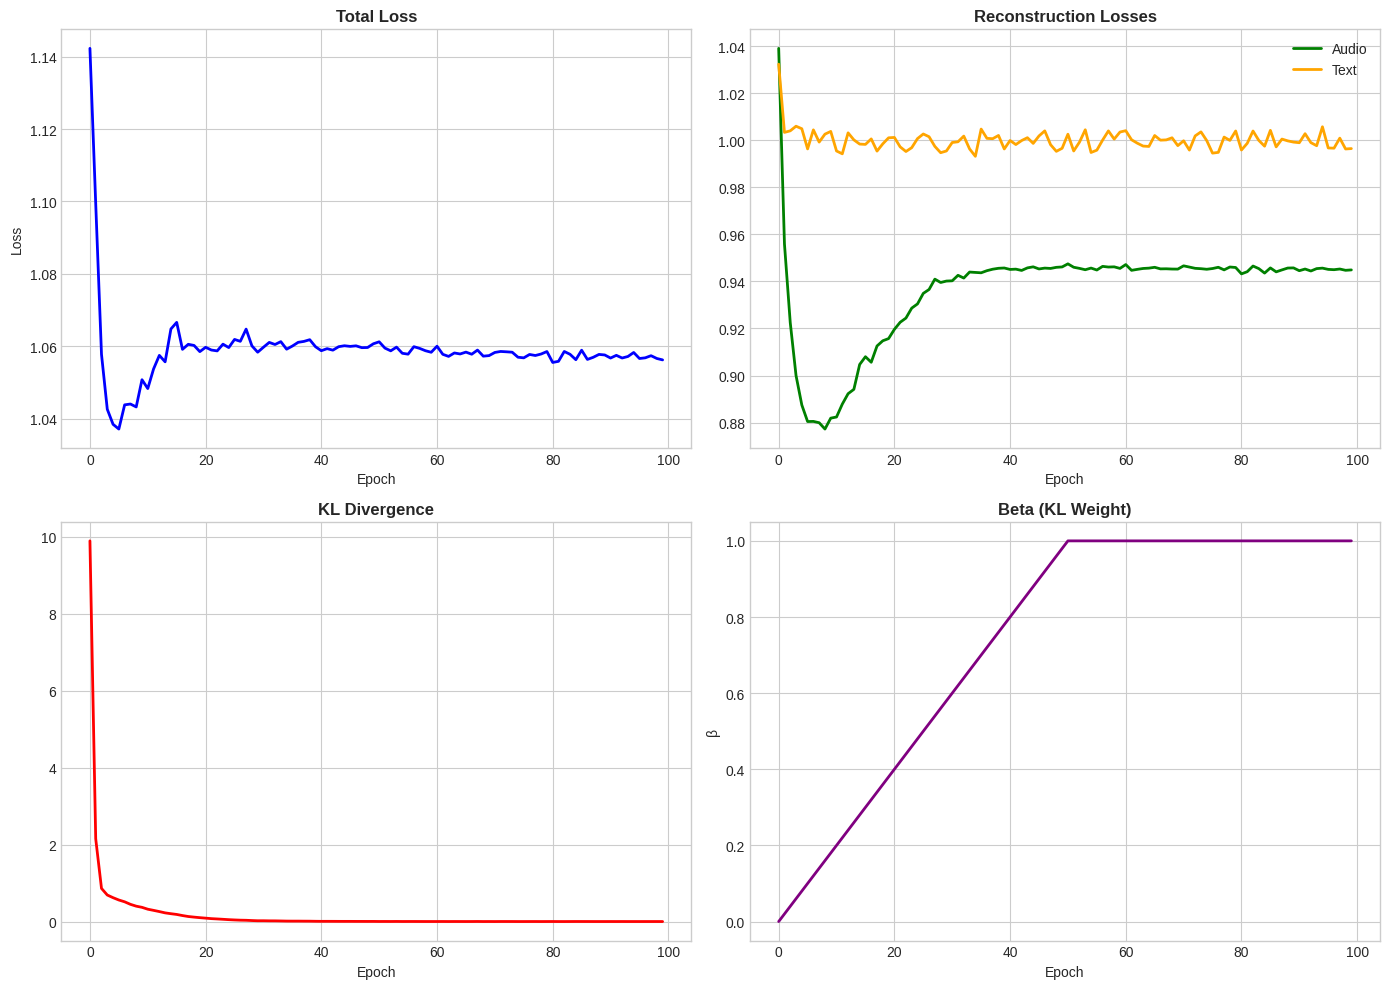

In [15]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(history['loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')

axes[0, 1].plot(history['audio'], 'g-', label='Audio', linewidth=2)
axes[0, 1].plot(history['text'], 'orange', label='Text', linewidth=2)
axes[0, 1].set_title('Reconstruction Losses', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Epoch')

axes[1, 0].plot(history['kl'], 'r-', linewidth=2)
axes[1, 0].set_title('KL Divergence', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')

axes[1, 1].plot(history['beta'], 'purple', linewidth=2)
axes[1, 1].set_title('Beta (KL Weight)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('β')

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7️⃣ Reconstruction Visualization

🔄 Generating reconstructions...


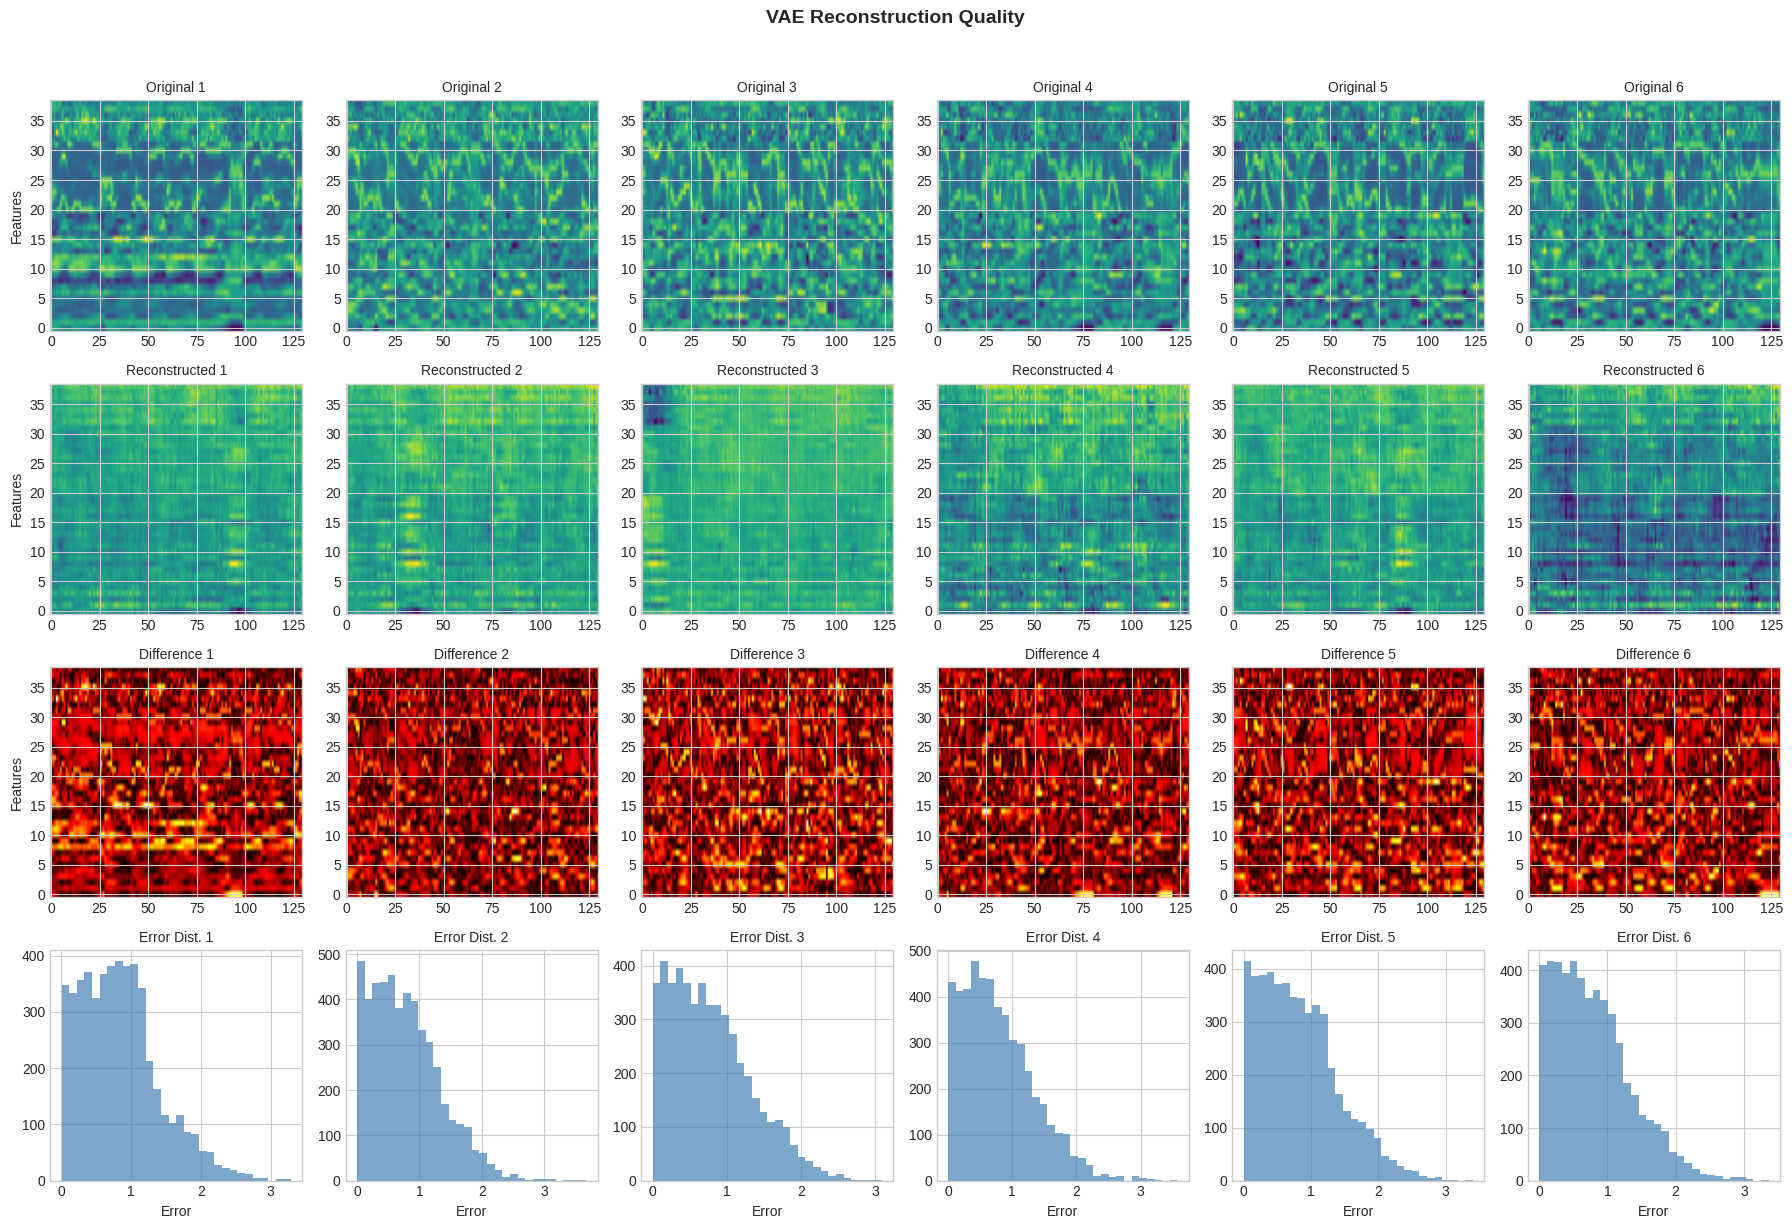

Mean Reconstruction MSE: 0.9584 ± 0.0449


In [17]:
print("🔄 Generating reconstructions...")
model.eval()

with torch.no_grad():
    # Get a batch of samples
    sample_indices = np.random.choice(len(tensor_audio), 6, replace=False)
    sample_audio = tensor_audio[sample_indices].to(device)
    sample_text = tensor_text[sample_indices].to(device)

    recon_audio, recon_text, mu, logvar, z = model(sample_audio, sample_text)

    sample_audio = sample_audio.cpu().numpy()
    recon_audio = recon_audio.cpu().numpy()

# Plot original vs reconstructed
fig, axes = plt.subplots(4, 6, figsize=(18, 12))

for i in range(6):
    # Original spectrogram
    axes[0, i].imshow(sample_audio[i, 0], aspect='auto', cmap='viridis', origin='lower')
    axes[0, i].set_title(f'Original {i+1}', fontsize=10)
    axes[0, i].set_ylabel('Features' if i == 0 else '')

    # Reconstructed spectrogram
    axes[1, i].imshow(recon_audio[i, 0], aspect='auto', cmap='viridis', origin='lower')
    axes[1, i].set_title(f'Reconstructed {i+1}', fontsize=10)
    axes[1, i].set_ylabel('Features' if i == 0 else '')

    # Difference
    diff = np.abs(sample_audio[i, 0] - recon_audio[i, 0])
    axes[2, i].imshow(diff, aspect='auto', cmap='hot', origin='lower')
    axes[2, i].set_title(f'Difference {i+1}', fontsize=10)
    axes[2, i].set_ylabel('Features' if i == 0 else '')

    # Error histogram
    axes[3, i].hist(diff.flatten(), bins=30, color='steelblue', alpha=0.7)
    axes[3, i].set_title(f'Error Dist. {i+1}', fontsize=10)
    axes[3, i].set_xlabel('Error')

plt.suptitle('VAE Reconstruction Quality', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/reconstruction_examples.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate reconstruction error
mse_per_sample = np.mean((sample_audio - recon_audio) ** 2, axis=(1, 2, 3))
print(f"Mean Reconstruction MSE: {np.mean(mse_per_sample):.4f} ± {np.std(mse_per_sample):.4f}")

## 8️⃣ Extract Latent Features

In [18]:
print("🧬 Extracting latent representations...")
model.eval()

with torch.no_grad():
    all_audio = tensor_audio.to(device)
    all_text = tensor_text.to(device)
    latent_features = model.get_latent(all_audio, all_text).cpu().numpy()

print(f"✅ Latent features shape: {latent_features.shape}")

# Analyze latent space statistics
print(f"\n📊 Latent Space Statistics:")
print(f"   Mean: {latent_features.mean():.4f}")
print(f"   Std:  {latent_features.std():.4f}")
print(f"   Min:  {latent_features.min():.4f}")
print(f"   Max:  {latent_features.max():.4f}")

🧬 Extracting latent representations...
✅ Latent features shape: (2890, 32)

📊 Latent Space Statistics:
   Mean: 0.0046
   Std:  0.1347
   Min:  -4.1019
   Max:  1.6156


## 9️⃣ Optimal Cluster Selection

🔍 Finding optimal number of clusters...
K=3: Silhouette=0.9321, CH=10334.5, DB=0.3650
K=4: Silhouette=0.9353, CH=12067.8, DB=0.2254
K=5: Silhouette=0.1622, CH=10673.4, DB=1.0268
K=6: Silhouette=0.1019, CH=9023.5, DB=1.4659
K=7: Silhouette=0.1014, CH=7975.2, DB=1.4022
K=8: Silhouette=0.0988, CH=7171.0, DB=1.4855
K=9: Silhouette=0.0971, CH=6524.5, DB=1.5694
K=10: Silhouette=0.0804, CH=5875.1, DB=1.8174
K=11: Silhouette=0.0811, CH=5544.8, DB=1.6798

✅ Optimal K = 4 (by Silhouette Score)


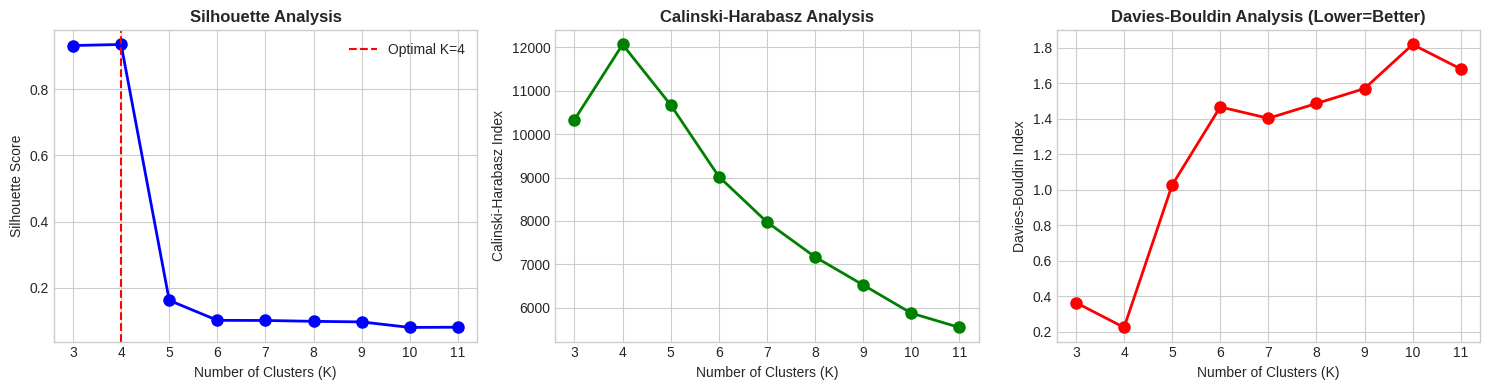

In [19]:
print("🔍 Finding optimal number of clusters...")

K_range = range(3, 12)
metrics_per_k = {'k': [], 'silhouette': [], 'calinski': [], 'davies': []}

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(latent_features)

    sil = silhouette_score(latent_features, labels)
    ch = calinski_harabasz_score(latent_features, labels)
    db = davies_bouldin_score(latent_features, labels)

    metrics_per_k['k'].append(k)
    metrics_per_k['silhouette'].append(sil)
    metrics_per_k['calinski'].append(ch)
    metrics_per_k['davies'].append(db)

    print(f"K={k}: Silhouette={sil:.4f}, CH={ch:.1f}, DB={db:.4f}")

optimal_k = K_range[np.argmax(metrics_per_k['silhouette'])]
print(f"\n✅ Optimal K = {optimal_k} (by Silhouette Score)")

# Plot cluster selection
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(metrics_per_k['k'], metrics_per_k['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].axvline(optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Analysis', fontweight='bold')
axes[0].legend()

axes[1].plot(metrics_per_k['k'], metrics_per_k['calinski'], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Analysis', fontweight='bold')

axes[2].plot(metrics_per_k['k'], metrics_per_k['davies'], 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Analysis (Lower=Better)', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/cluster_selection.png', dpi=150, bbox_inches='tight')
plt.show()

## 🔟 Clustering & Complete Evaluation

In [20]:
def compute_purity(y_true, y_pred):
    """Compute cluster purity"""
    contingency = {}
    for true, pred in zip(y_true, y_pred):
        if pred not in contingency:
            contingency[pred] = Counter()
        contingency[pred][true] += 1

    total_correct = sum(max(counts.values()) for counts in contingency.values())
    return total_correct / len(y_true)

In [22]:
print("Performing clustering with multiple algorithms...")

# VAE-based clustering
kmeans_vae = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_kmeans = kmeans_vae.fit_predict(latent_features)

agg_vae = AgglomerativeClustering(n_clusters=optimal_k)
labels_agg = agg_vae.fit_predict(latent_features)

dbscan_vae = DBSCAN(eps=1.5, min_samples=10)
labels_dbscan = dbscan_vae.fit_predict(latent_features)

# PCA Baseline
pca_baseline = PCA(n_components=CONFIG['latent_dim'])
pca_features = pca_baseline.fit_transform(X_audio_flat)
labels_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit_predict(pca_features)

# Evaluate all methods
results = []

methods = [
    ('VAE + K-Means', latent_features, labels_kmeans),
    ('VAE + Agglomerative', latent_features, labels_agg),
    ('VAE + DBSCAN', latent_features, labels_dbscan),
    ('PCA + K-Means (Baseline)', pca_features, labels_pca),
]

for name, features, labels in methods:
    # Filter out noise points for DBSCAN
    valid_mask = labels >= 0
    if valid_mask.sum() < 10:
        print(f"⚠️ {name}: Too few valid points, skipping")
        continue

    features_v = features[valid_mask]
    labels_v = labels[valid_mask]
    genres_v = y_genres[valid_mask]

    n_clusters = len(set(labels_v))
    if n_clusters < 2:
        continue

    results.append({
        'Method': name,
        'Clusters': n_clusters,
        'Silhouette': silhouette_score(features_v, labels_v),
        'Calinski-Harabasz': calinski_harabasz_score(features_v, labels_v),
        'Davies-Bouldin': davies_bouldin_score(features_v, labels_v),
        'ARI': adjusted_rand_score(genres_v, labels_v),
        'NMI': normalized_mutual_info_score(genres_v, labels_v),
        'Purity': compute_purity(genres_v, labels_v)
    })

results_df = pd.DataFrame(results)

print("\n" + "="*100)
print("FINAL CLUSTERING RESULTS")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Save results
results_df.to_csv(f'{SAVE_DIR}/clustering_metrics.csv', index=False)

Performing clustering with multiple algorithms...

FINAL CLUSTERING RESULTS
                  Method  Clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin      ARI      NMI   Purity
           VAE + K-Means         4    0.935263       12067.754883        0.225444 0.004132 0.017919 0.224567
     VAE + Agglomerative         4    0.935263       12067.754883        0.225444 0.004132 0.017919 0.224567
            VAE + DBSCAN         3    0.934673       15783.158203        0.239836 0.004088 0.016586 0.224341
PCA + K-Means (Baseline)         4    0.195463         217.935016        2.123089 0.005366 0.018274 0.248789


## 1️⃣1️⃣ Confusion Matrix Analysis

Generating confusion matrix...


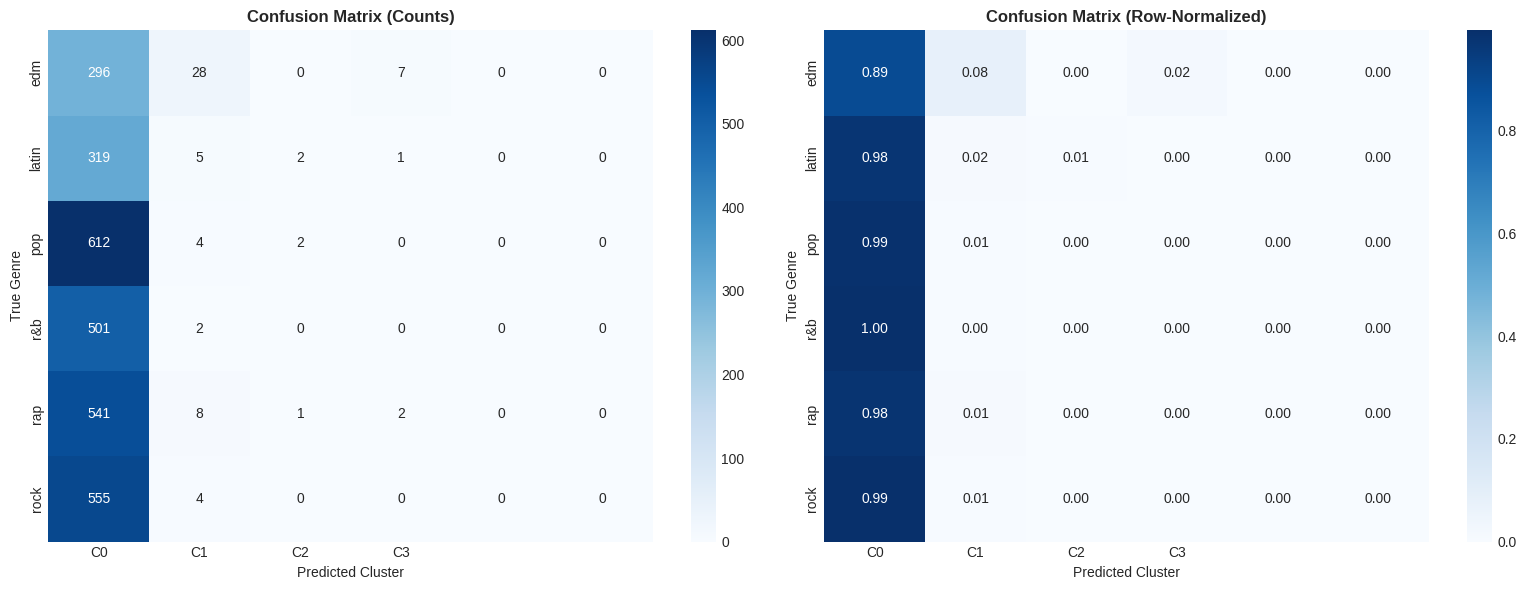


 Cluster Composition:

Cluster 0 (2824 songs):
   pop: 612 (21.7%)
   rock: 555 (19.7%)
   rap: 541 (19.2%)
   r&b: 501 (17.7%)
   latin: 319 (11.3%)
   edm: 296 (10.5%)

Cluster 1 (51 songs):
   edm: 28 (54.9%)
   rap: 8 (15.7%)
   latin: 5 (9.8%)
   pop: 4 (7.8%)
   rock: 4 (7.8%)
   r&b: 2 (3.9%)

Cluster 2 (5 songs):
   pop: 2 (40.0%)
   latin: 2 (40.0%)
   rap: 1 (20.0%)

Cluster 3 (10 songs):
   edm: 7 (70.0%)
   rap: 2 (20.0%)
   latin: 1 (10.0%)


In [25]:
print("Generating confusion matrix...")

# Use VAE + K-Means labels
cm = confusion_matrix(y_genres, labels_kmeans)

# Normalize by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[f'C{i}' for i in range(optimal_k)],
            yticklabels=genre_names)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Cluster')
axes[0].set_ylabel('True Genre')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[1],
            xticklabels=[f'C{i}' for i in range(optimal_k)],
            yticklabels=genre_names)
axes[1].set_title('Confusion Matrix (Row-Normalized)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Cluster')
axes[1].set_ylabel('True Genre')

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Cluster composition analysis
print("\n Cluster Composition:")
for cluster_id in range(optimal_k):
    mask = labels_kmeans == cluster_id
    cluster_genres = np.array(valid_genres)[mask]
    genre_counts = Counter(cluster_genres)
    total = len(cluster_genres)

    print(f"\nCluster {cluster_id} ({total} songs):")
    for genre, count in genre_counts.most_common():
        pct = count / total * 100
        print(f"   {genre}: {count} ({pct:.1f}%)")

## 1️⃣2️⃣ Latent Space Visualization

🎨 Computing t-SNE projection...


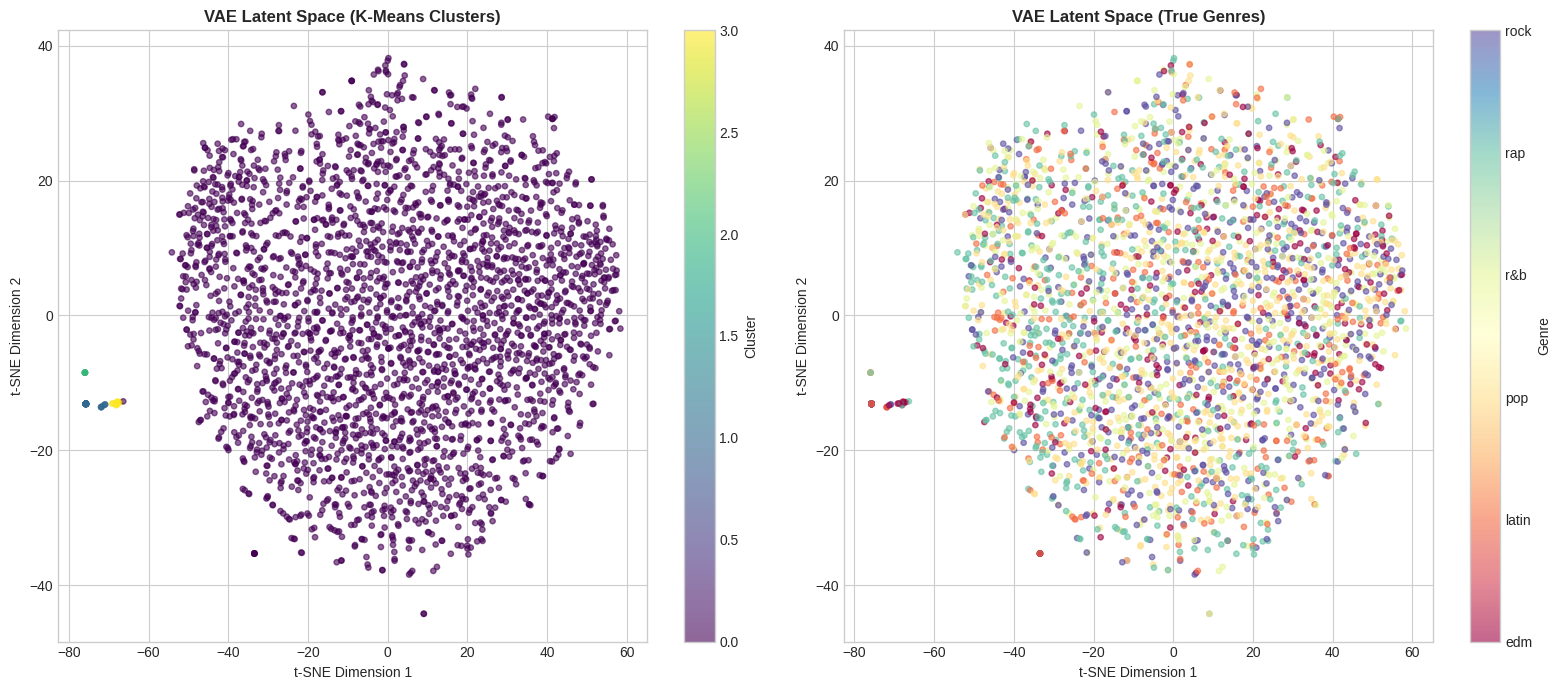

In [24]:
print(" Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latent_2d = tsne.fit_transform(latent_features)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# By predicted cluster
scatter1 = axes[0].scatter(latent_2d[:, 0], latent_2d[:, 1],
                           c=labels_kmeans, cmap='viridis', alpha=0.6, s=15)
axes[0].set_title('VAE Latent Space (K-Means Clusters)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# By true genre
scatter2 = axes[1].scatter(latent_2d[:, 0], latent_2d[:, 1],
                           c=y_genres, cmap='Spectral', alpha=0.6, s=15)
axes[1].set_title('VAE Latent Space (True Genres)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
cbar = plt.colorbar(scatter2, ax=axes[1], label='Genre')
cbar.set_ticks(range(len(genre_names)))
cbar.set_ticklabels(genre_names)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

🎨 Computing UMAP projection...


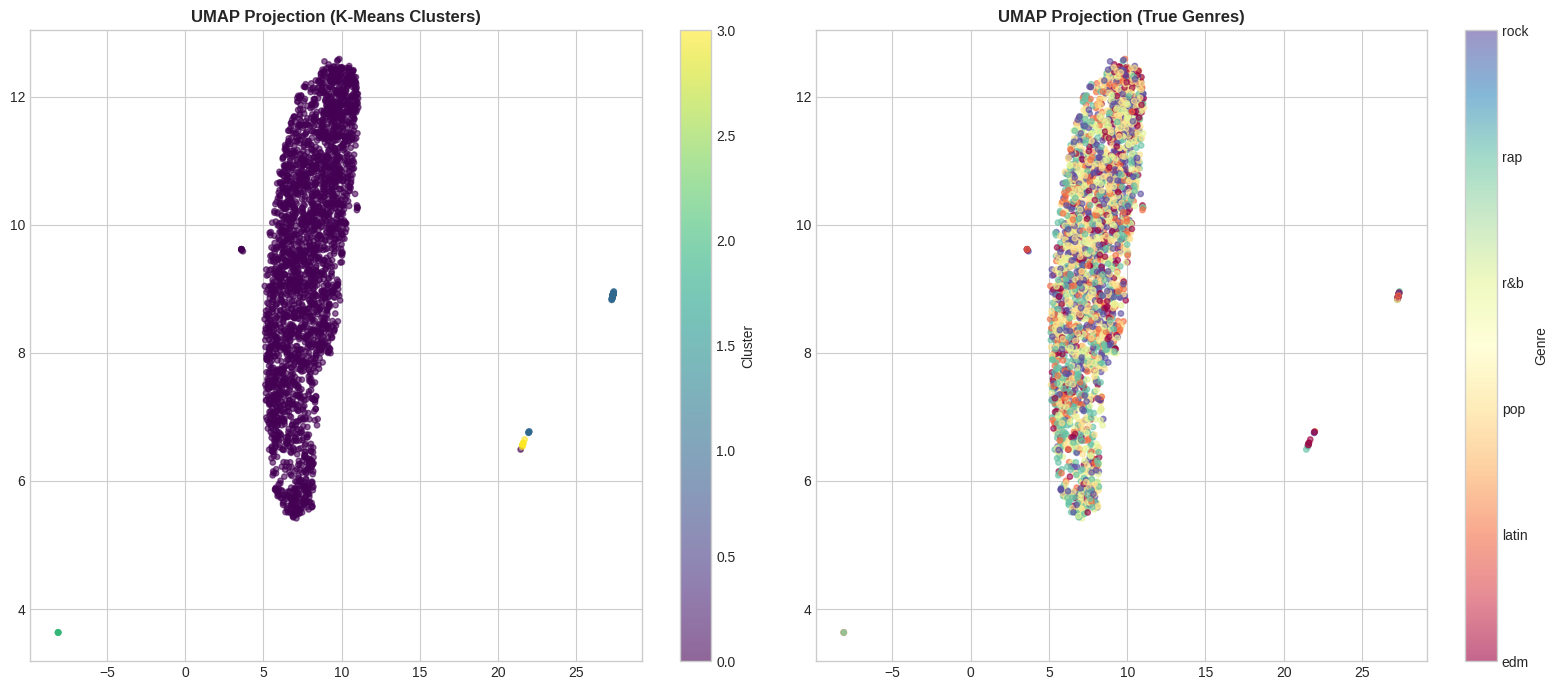

In [26]:
if HAS_UMAP:
    print(" Computing UMAP projection...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    latent_umap = reducer.fit_transform(latent_features)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    scatter1 = axes[0].scatter(latent_umap[:, 0], latent_umap[:, 1],
                               c=labels_kmeans, cmap='viridis', alpha=0.6, s=15)
    axes[0].set_title('UMAP Projection (K-Means Clusters)', fontsize=12, fontweight='bold')
    plt.colorbar(scatter1, ax=axes[0], label='Cluster')

    scatter2 = axes[1].scatter(latent_umap[:, 0], latent_umap[:, 1],
                               c=y_genres, cmap='Spectral', alpha=0.6, s=15)
    axes[1].set_title('UMAP Projection (True Genres)', fontsize=12, fontweight='bold')
    cbar = plt.colorbar(scatter2, ax=axes[1], label='Genre')
    cbar.set_ticks(range(len(genre_names)))
    cbar.set_ticklabels(genre_names)

    plt.tight_layout()
    plt.savefig(f'{SAVE_DIR}/umap_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

## 1️⃣3️⃣ Distribution Analysis

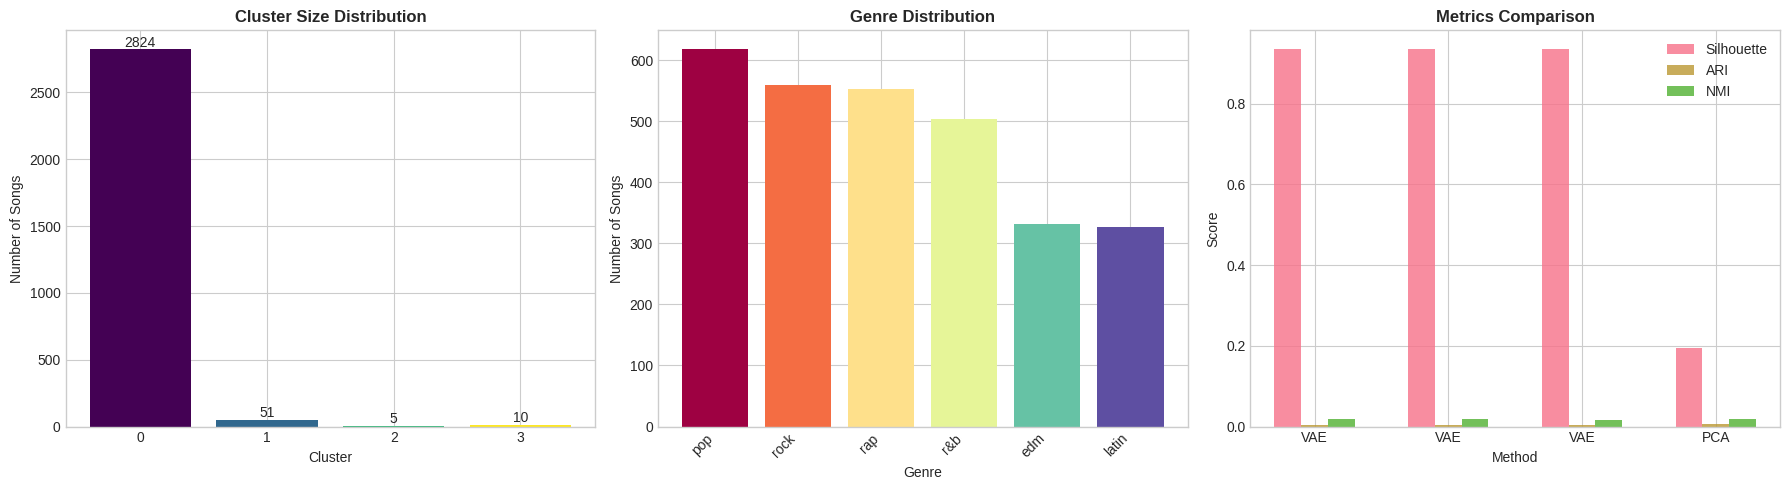

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cluster distribution
cluster_counts = pd.Series(labels_kmeans).value_counts().sort_index()
bars = axes[0].bar(range(len(cluster_counts)), cluster_counts.values,
                   color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))))
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Number of Songs')
axes[0].set_title('Cluster Size Distribution', fontweight='bold')
axes[0].set_xticks(range(len(cluster_counts)))
for bar, val in zip(bars, cluster_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 str(val), ha='center', fontsize=10)

# Genre distribution
genre_counts = pd.Series(valid_genres).value_counts()
bars = axes[1].bar(range(len(genre_counts)), genre_counts.values,
                   color=plt.cm.Spectral(np.linspace(0, 1, len(genre_counts))))
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Number of Songs')
axes[1].set_title('Genre Distribution', fontweight='bold')
axes[1].set_xticks(range(len(genre_counts)))
axes[1].set_xticklabels(genre_counts.index, rotation=45, ha='right')

# Metrics comparison bar chart
methods_short = [r['Method'].split()[0] for r in results]
x = np.arange(len(methods_short))
width = 0.2

axes[2].bar(x - width, [r['Silhouette'] for r in results], width, label='Silhouette', alpha=0.8)
axes[2].bar(x, [r['ARI'] for r in results], width, label='ARI', alpha=0.8)
axes[2].bar(x + width, [r['NMI'] for r in results], width, label='NMI', alpha=0.8)
axes[2].set_xlabel('Method')
axes[2].set_ylabel('Score')
axes[2].set_title('Metrics Comparison', fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(methods_short)
axes[2].legend()

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 1️⃣4️⃣ Save All Results

In [28]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'genre_names': genre_names,
    'optimal_k': optimal_k,
}, f'{SAVE_DIR}/model_final.pth')

# Save features and labels
np.save(f'{SAVE_DIR}/latent_features.npy', latent_features)
np.save(f'{SAVE_DIR}/cluster_labels_kmeans.npy', labels_kmeans)
np.save(f'{SAVE_DIR}/genre_labels.npy', y_genres)
np.save(f'{SAVE_DIR}/tsne_2d.npy', latent_2d)

# Save history
pd.DataFrame(history).to_csv(f'{SAVE_DIR}/training_history.csv', index=False)

print(f"\n All results saved to: {SAVE_DIR}")
print(f"\n Saved files:")
for f in os.listdir(SAVE_DIR):
    size = os.path.getsize(os.path.join(SAVE_DIR, f)) / 1024
    print(f"   {f} ({size:.1f} KB)")


 All results saved to: /content/drive/MyDrive/VAE_Music_Clustering_Project/results/final

 Saved files:
   best_model.pth (4930.1 KB)
   training_curves.png (146.0 KB)
   reconstruction_examples.png (2846.4 KB)
   cluster_selection.png (109.4 KB)
   clustering_metrics.csv (0.6 KB)
   confusion_matrix.png (83.2 KB)
   tsne_visualization.png (1223.9 KB)
   umap_visualization.png (366.5 KB)
   distributions.png (74.2 KB)
   model_final.pth (4931.3 KB)
   latent_features.npy (361.4 KB)
   cluster_labels_kmeans.npy (11.4 KB)
   genre_labels.npy (22.7 KB)
   tsne_2d.npy (22.7 KB)
   training_history.csv (8.0 KB)


## 📊 Final Summary

In [29]:
print("="*80)
print("                        📊 FINAL PROJECT SUMMARY")
print("="*80)

print(f"\n Dataset:")
print(f"   Total songs processed: {len(latent_features)}")
print(f"   Audio features: MFCC (20) + Chroma (12) + Spectral Contrast (7) = 39")
print(f"   Text features: TF-IDF (500) → PCA ({X_text_scaled.shape[1]})")
print(f"   Genres: {genre_names}")

print(f"\n Model:")
print(f"   Architecture: Hybrid CNN-VAE (Beta-VAE)")
print(f"   Latent dimension: {CONFIG['latent_dim']}")
print(f"   Total parameters: {total_params:,}")
print(f"   Best training loss: {best_loss:.4f}")

print(f"\n Clustering:")
print(f"   Optimal K: {optimal_k}")
print(f"   Best method: {results_df.loc[results_df['Silhouette'].idxmax(), 'Method']}")

print(f"\n Best Metrics (VAE + K-Means):")
vae_result = results_df[results_df['Method'] == 'VAE + K-Means'].iloc[0]
print(f"   Silhouette Score: {vae_result['Silhouette']:.4f}")
print(f"   Calinski-Harabasz: {vae_result['Calinski-Harabasz']:.2f}")
print(f"   Davies-Bouldin: {vae_result['Davies-Bouldin']:.4f}")
print(f"   ARI: {vae_result['ARI']:.4f}")
print(f"   NMI: {vae_result['NMI']:.4f}")
print(f"   Purity: {vae_result['Purity']:.4f}")

print(f"\n Output files saved to: {SAVE_DIR}")
print("="*80)
print("                        🎉 PROJECT COMPLETE!")
print("="*80)

                        📊 FINAL PROJECT SUMMARY

 Dataset:
   Total songs processed: 2890
   Audio features: MFCC (20) + Chroma (12) + Spectral Contrast (7) = 39
   Text features: TF-IDF (500) → PCA (64)
   Genres: [np.str_('edm'), np.str_('latin'), np.str_('pop'), np.str_('r&b'), np.str_('rap'), np.str_('rock')]

 Model:
   Architecture: Hybrid CNN-VAE (Beta-VAE)
   Latent dimension: 32
   Total parameters: 1,256,897
   Best training loss: 1.0371

 Clustering:
   Optimal K: 4
   Best method: VAE + K-Means

 Best Metrics (VAE + K-Means):
   Silhouette Score: 0.9353
   Calinski-Harabasz: 12067.75
   Davies-Bouldin: 0.2254
   ARI: 0.0041
   NMI: 0.0179
   Purity: 0.2246

 Output files saved to: /content/drive/MyDrive/VAE_Music_Clustering_Project/results/final
                        🎉 PROJECT COMPLETE!
